# CP and MRI measures + Disability

## Setup

### Imports

In [25]:
from warnings import simplefilter

import pandas as pd
from IPython.display import Markdown, display

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colormaps
from reload_recursive import reload_recursive
from scipy import stats
import pyperclip

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import my_namespace
import regression_utils as regutils
import utils

#### Reload imports 

In [26]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import regression_utils as regutils
import utils
from my_namespace import presentation_cols, colors
from utils import zscore

### Load Data

#### Clinical and Volumes

In [27]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/2-CP_and_MRI_disease_measures"
)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")

viridis = colormaps["viridis"].resampled(20)

MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

## Analysis

### Univariate associations with CP

Univariable assessments showed that enlargement of CP  is significantly associated with older age (β=0.40, p<0.001) and male sex (β=0.28, p<0.001), and TIV (β=0.15, p=0.0013). 

In [4]:
model_data = data[MS_patients]
model_data_z = zscore(model_data)

text = ""

result = stats.pearsonr(model_data['CP'], model_data['age'])
text += "**Age**:\n\n"
text += f"r={result.statistic:.3}, p={result.pvalue:.2}\n\n"

result = stats.pearsonr(model_data['CP'], model_data['Male'])
text += "**Male Sex**:\n\n"
text += f"r={result.statistic:.3}, p={result.pvalue:.2}\n\n"

result = stats.pearsonr(model_data['CP'], model_data['TIV'])
text += "**TIV**:\n\n"
text += f"r={result.statistic:.3}, p={result.pvalue:.2}\n\n"

display(Markdown(text))

**Age**:

r=0.395, p=6.1e-19

**Male Sex**:

r=0.284, p=3.9e-10

**TIV**:

r=0.145, p=0.0017



### MRI and clinical measures versus CP 

#### Continuous MRI measures of MS severity

The volumetric relationships (standardized coefficients) between CP and MRI and clinical variables is summarized in Table 2 and Figure 1. 

CP showed the strongest relationships with Whole Thalamic Volume (WTV) (β=-0.42, p<0.001), followed by T2LV (β=0.34, p<0.001) and cortical thickness (β=-0.33, p<0.001). There were smaller, significant inverse relationships between CP and Whole Brain Volume (WBV), Gray Matter Volume (GMV), and White Matter Volume (WMV; all p<0.01).

In [37]:
model_data = data[MS_patients]
model_data = zscore(model_data)

presentation_cols_tmp = presentation_cols + ["ΔR2"]

outcomes = [
    "T2LV_log1p",
    "WTV",
    "WBV",
    "GMV",
    "WMV",
    "cortical_thickness",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates,
    to_check_vif=False,
)

_, results2, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    ["age"],
    covariates,
    to_check_vif=False,
)

_, results3, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    ["CP"],
    [],
    to_check_vif=False,
)

results = results[predictor]
results['ΔR2'] = results['R2'] - results2['age']['R2']
display_order = results["coef"].apply(np.abs).sort_values(ascending=False).index

display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results.loc[display_order, :], presentation_cols_tmp).to_markdown())
)

save_path = fig_path / "choroid_associations.xlsx"

with pd.ExcelWriter(save_path, mode='a') as writer:
    save_df = regutils.present_model(results.loc[display_order, :], presentation_cols_tmp)
    save_df.to_excel(writer, sheet_name="main")

**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome            |    coef |   p_fdr |     se | ci               |   R2 |    ΔR2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|-------:|
| WTV                | -0.4179 | 1.1e-18 | 0.0471 | [-0.51, -0.326]  | 0.43 | 0.1376 |
| T2LV_log1p         |  0.3544 | 4.9e-13 | 0.0489 | [0.259, 0.45]    | 0.2  | 0.0981 |
| cortical_thickness | -0.3243 | 1.7e-12 | 0.046  | [-0.414, -0.234] | 0.32 | 0.0821 |
| WBV                | -0.2574 | 2.6e-41 | 0.0189 | [-0.294, -0.22]  | 0.88 | 0.0524 |
| GMV                | -0.2551 | 5.7e-28 | 0.0231 | [-0.3, -0.21]    | 0.78 | 0.0512 |
| WMV                | -0.2301 | 5.9e-21 | 0.0243 | [-0.278, -0.182] | 0.83 | 0.0417 |

In [13]:
model_data = data[MS_patients]
model_data = zscore(model_data)

outcomes = [
    "T2LV_log1p",
    "periventricular_T2LV_log1p",
    "subcortical_T2LV_log1p",
    "juxtacortical_T2LV_log1p",
    "infratentorial_T2LV_log1p",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

results = results[predictor]
display_order = results["coef"].apply(np.abs).sort_values(ascending=False).index

display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results.loc[display_order, :], presentation_cols).to_markdown())
)

**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome                    |   coef |   p_fdr |     se | ci             |    R2 |
|:---------------------------|-------:|--------:|-------:|:---------------|------:|
| T2LV_log1p                 | 0.364  | 3.3e-13 | 0.0486 | [0.269, 0.459] | 0.21  |
| periventricular_T2LV_log1p | 0.3545 | 5.6e-11 | 0.053  | [0.251, 0.458] | 0.19  |
| juxtacortical_T2LV_log1p   | 0.2986 | 1.9e-08 | 0.0523 | [0.196, 0.401] | 0.11  |
| subcortical_T2LV_log1p     | 0.2358 | 1.3e-05 | 0.0535 | [0.131, 0.341] | 0.075 |
| infratentorial_T2LV_log1p  | 0.1795 | 0.0006  | 0.0523 | [0.077, 0.282] | 0.042 |

#### PRL Count

PRL count must be modeled with a Poisson distribution, which means the β here is not directly comparable to the ones above. 

Larger CP was also associated with the number of paramagnetic rim lesions (PRL; β=0.43, p<0.001), even after adjusting for the total T2LV (β=0.31, p<0.001). 

I added a third model with an interaction term for CP and T2LV. But does this even make sense to report? PRL's are basically T2 lesions with a rim. Try to think of this in a mechanistic way to figure it out

In [44]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
model_formulas = {
    "basic": "PRL ~ age + Female + tiv",
    "CP": "PRL ~ CP + age + Female + tiv",
    "CP + t2lv": "PRL ~ CP + t2lv_log + age + Female + tiv",
    "CP*t2lv": "PRL ~ CP*t2lv_log + age + Female + tiv",
    "CP + T2LV": "PRL ~ CP + T2LV_log1p + age + Female + tiv",
    "CP*T2LV": "PRL ~ CP*T2LV_log1p + age + Female + tiv",
    "WTV": "PRL ~ WTV + age + Female + tiv",
    "WTV + posterior": "PRL ~ WTV + posterior + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions_from_formulas(
    model_data,
    model_formulas.values(),
    model_names=model_formulas.keys(),
    regression_model="GLM",
    family=sm.families.Poisson(),
    to_check_vif=False,
)



with pd.ExcelWriter(save_path, mode='a', if_sheet_exists='replace') as writer:
    result = results['CP']
    result['ΔR2'] = result['R2'] - results['basic']['R2'][0]
    save_df = result.loc[["CP"], :]
    save_df.to_excel(writer, sheet_name="PRL")

for formula, result in zip(formulas.values(), results.values()):
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(regutils.present_model(result, exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"]).to_markdown())
    )

```R
PRL ~ age + Female + tiv
```


| coef   | pval   | se   | llci   | ulci   | ci   | R2   |
|--------|--------|------|--------|--------|------|------|

```R
PRL ~ CP + age + Female + tiv
```


|    |   coef |    pval |     se |   llci |   ulci | ci             |   R2 |    ΔR2 |
|:---|-------:|--------:|-------:|-------:|-------:|:---------------|-----:|-------:|
| CP | 0.4313 | 3.1e-05 | 0.1036 | 0.2283 | 0.6343 | [0.228, 0.634] | 0.32 | 0.0994 |

```R
PRL ~ CP + t2lv_log + age + Female + tiv
```


|          |   coef |    pval |     se |   llci |   ulci | ci              |   R2 |
|:---------|-------:|--------:|-------:|-------:|-------:|:----------------|-----:|
| CP       | 0.2958 | 0.011   | 0.1169 | 0.0667 | 0.525  | [0.0667, 0.525] | 0.38 |
| t2lv_log | 0.3197 | 7.1e-05 | 0.0805 | 0.162  | 0.4775 | [0.162, 0.477]  | 0.38 |

```R
PRL ~ CP*t2lv_log + age + Female + tiv
```


|             |    coef |    pval |     se |    llci |    ulci | ci                |   R2 |
|:------------|--------:|--------:|-------:|--------:|--------:|:------------------|-----:|
| CP          |  0.3421 | 0.0032  | 0.1161 |  0.1146 |  0.5697 | [0.115, 0.57]     |  0.4 |
| t2lv_log    |  0.3385 | 1.6e-05 | 0.0784 |  0.1849 |  0.4922 | [0.185, 0.492]    |  0.4 |
| CP:t2lv_log | -0.1772 | 0.021   | 0.077  | -0.3282 | -0.0262 | [-0.328, -0.0262] |  0.4 |

```R
PRL ~ CP + T2LV_log1p + age + Female + tiv
```


|            |   coef |   pval |     se |    llci |   ulci | ci              |   R2 |
|:-----------|-------:|-------:|-------:|--------:|-------:|:----------------|-----:|
| CP         | 0.1424 |  0.24  | 0.1212 | -0.0952 | 0.38   | [-0.0952, 0.38] | 0.52 |
| T2LV_log1p | 0.7912 |  1e-11 | 0.1163 |  0.5632 | 1.0191 | [0.563, 1.02]   | 0.52 |

```R
PRL ~ CP*T2LV_log1p + age + Female + tiv
```


|               |    coef |    pval |     se |    llci |    ulci | ci                |   R2 |
|:--------------|--------:|--------:|-------:|--------:|--------:|:------------------|-----:|
| CP            |  0.2561 | 0.041   | 0.1253 |  0.0106 |  0.5017 | [0.0106, 0.502]   | 0.53 |
| T2LV_log1p    |  0.8328 | 1.1e-16 | 0.1004 |  0.636  |  1.0296 | [0.636, 1.03]     | 0.53 |
| CP:T2LV_log1p | -0.2786 | 0.033   | 0.1306 | -0.5346 | -0.0227 | [-0.535, -0.0227] | 0.53 |

```R
PRL ~ WTV + age + Female + tiv
```


|     |    coef |    pval |     se |   llci |    ulci | ci               |   R2 |
|:----|--------:|--------:|-------:|-------:|--------:|:-----------------|-----:|
| WTV | -0.5843 | 6.4e-16 | 0.0723 | -0.726 | -0.4426 | [-0.726, -0.443] | 0.43 |

```R
PRL ~ WTV + posterior + age + Female + tiv
```


|           |    coef |    pval |     se |    llci |    ulci | ci             |   R2 |
|:----------|--------:|--------:|-------:|--------:|--------:|:---------------|-----:|
| WTV       |  0.3056 | 0.17    | 0.2218 | -0.1292 |  0.7404 | [-0.129, 0.74] | 0.48 |
| posterior | -0.9055 | 7.4e-06 | 0.202  | -1.3014 | -0.5095 | [-1.3, -0.51]  | 0.48 |

In [43]:
results['CP']['R2'] - results['basic']['R2'][0]

Intercept      0.099388
Female[T.1]    0.099388
CP             0.099388
age            0.099388
tiv            0.099388
Name: R2, dtype: float64

In [29]:
regutils.present_model(result.loc[display_order, :], presentation_cols)

KeyError: "None of [Index(['WTV', 'T2LV_log1p', 'cortical_thickness', 'WBV', 'GMV', 'WMV'], dtype='object', name='outcome')] are in the [index]"

#### Disability Measures

With respect to clinical measures, increased CP volume was associated with slower cognitive processing speed (SDMT; β=-0.16, p=0.005), but not physical disability as measured by the EDSS (β=0.071, p=0.11). 

In [99]:
outcomes = [
    "EDSS_sqrt",
    "SDMT"
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

display_order = results[predictor]["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results[predictor].loc[display_order, :], presentation_cols).to_markdown())
)

results = results[predictor]

**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome   |    coef |   pval |   p_fdr |     se | ci                |   R2 |
|:----------|--------:|-------:|--------:|-------:|:------------------|-----:|
| SDMT      | -0.158  | 0.0051 |    0.01 | 0.0561 | [-0.268, -0.0477] | 0.17 |
| EDSS_sqrt |  0.0711 | 0.11   |    0.11 | 0.0443 | [-0.0161, 0.158]  | 0.22 |

### Logistic regressions on disease status

CP does not distinguish MS from other neurological diseases

In [84]:
model_data = data.copy()[(MS_patients) | (NIND_patients)]
model_data = zscore(model_data)
model_data = model_data.join([pd.get_dummies(model_data['dz_type2'], dtype=int)])

outcome = "MS" # LV / allCSF
res = sm.OLS.from_formula("MS ~ CP + age + Female + tiv", data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     MS   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.628
Date:                Tue, 18 Nov 2025   Prob (F-statistic):             0.0339
Time:                        22:34:34   Log-Likelihood:                -89.003
No. Observations:                 516   AIC:                             188.0
Df Residuals:                     511   BIC:                             209.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9510      0.033     29.248      

## Plots

In [81]:
data_plotting = data.copy()
data_plotting['Female'] = pd.to_numeric(model_data['Female'])

def compute_se_diff(se1, n1, se2, n2):
    return np.sqrt((se1**2/n1) + (se2**2/n2))

def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    ylim = ax.get_ylim()

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color="gray", density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color="black")
    ax_histy.plot(densityy(xy), xy, color=dark_color)
    
    ax_histy.set_ylim(ylim)


def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None,
    color="blue1", light_color=None, dark_color=None
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"
    
    if light_color is None:
        light_color = f"light {color}"
    if dark_color is None:
        dark_color = f"dark {color}"
    light_color = colors[light_color]  
    dark_color = colors[dark_color]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    
    
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained'
    )
    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=light_color
    )
    scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=light_color,
        dark_color=dark_color,
    )

    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

In [83]:
colors

{'dark red1': '#eb3131',
 'light red1': '#eb7171',
 'dark blue1': '#1f4294',
 'light blue1': '#7a9df0',
 'dark green1': '#2e6023',
 'light green1': '#6dba5c',
 'dark purple1': '#8C1FA7',
 'light purple1': '#BD49DA'}

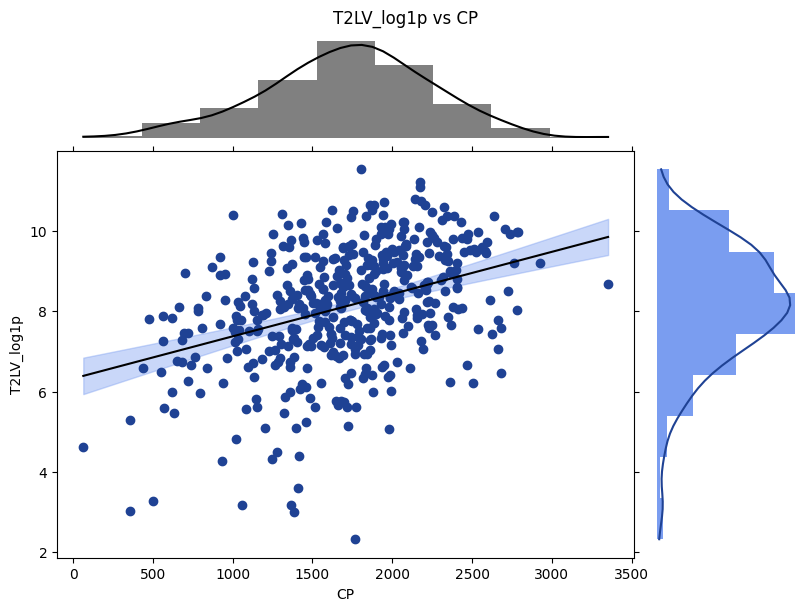

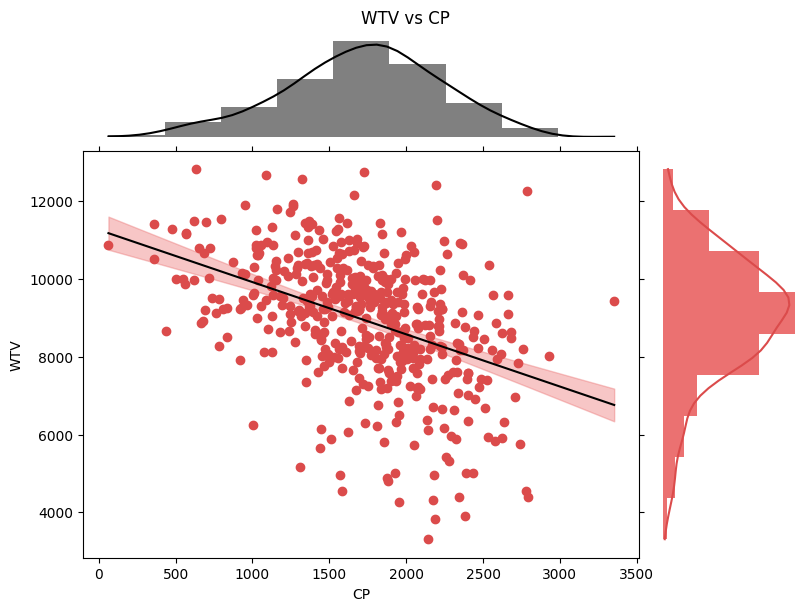

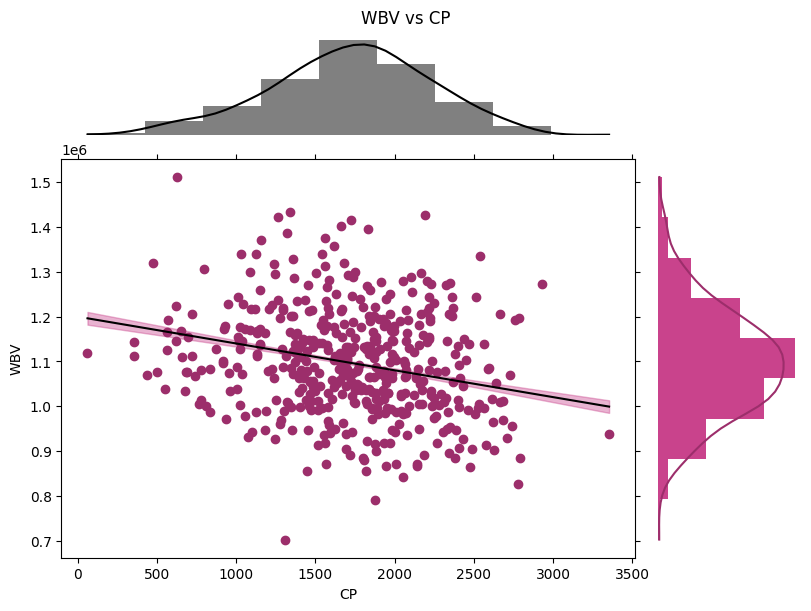

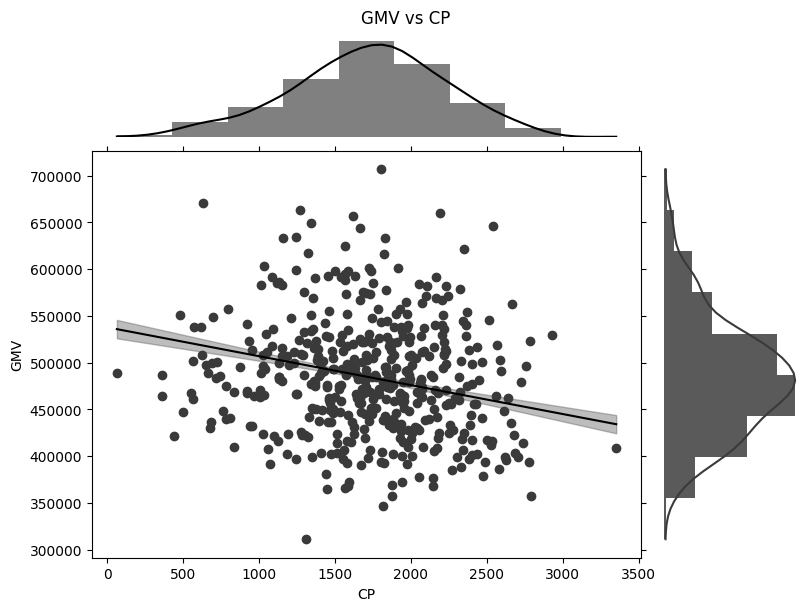

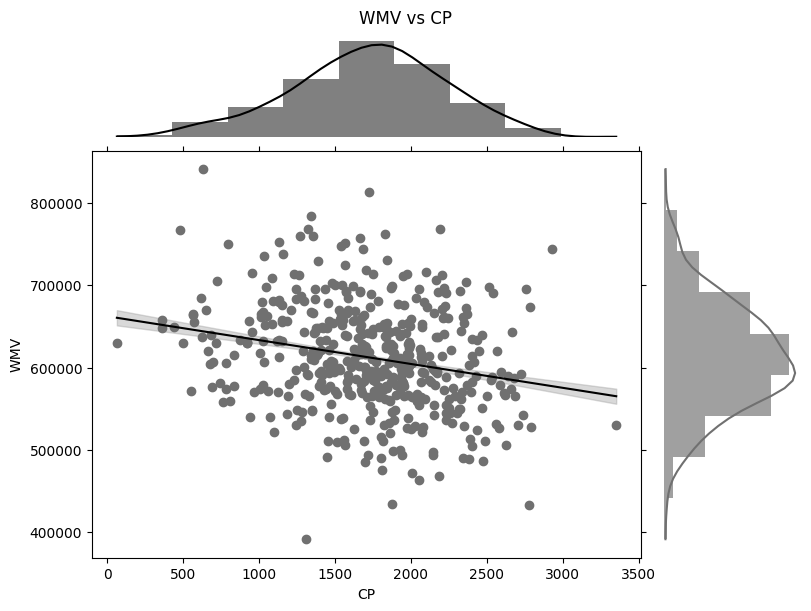

In [90]:
plot_data = data_plotting[MS_patients]

outcomes = [
    "T2LV_log1p",
    "WTV",
    "WBV",
    "GMV",
    "WMV",
    "cortical_thickness",
]

outcome_colors = {
    "T2LV_log1p": {'color': "blue1"},
    "WTV": {'light_color': "light red2", 'dark_color': "dark red2"},
    "WBV": {'light_color': "dark pink1", 'dark_color': "darker pink1"},
    "GMV": {'light_color': 'grey4', 'dark_color': 'grey2'},
    "WMV": {'light_color': 'grey8', 'dark_color': 'grey6'},
}

for outcome, color_kwargs in outcome_colors.items():
    plot_regression(plot_data, "CP", outcome, ["age", "Female", "tiv"], **color_kwargs)

## Extras

### Unstandardized Regressions

In [ ]:
model_data = data[MS_patients]

outcomes = [
    "THALAMUS_1",
    "cortical_thickness",
    "WBV",
    "GMV",
    "WMV",
    "t2lv_log",
]
model_data = zscore(model_data, skip_vars=outcomes)

covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

results = results[predictor]
display_order = results["coef"].apply(np.abs).sort_values(ascending=False).index

display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results.loc[display_order, :], presentation_cols).to_markdown())
)

**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome            |        coef |   p_fdr |        se | ci                     |   R2 |
|:-------------------|------------:|--------:|----------:|:-----------------------|-----:|
| WBV                | -30606.4    | 2.7e-41 | 2251.82   | [-3.5e+04, -2.62e+04]  | 0.88 |
| GMV                | -15788.3    | 6.1e-28 | 1427.93   | [-1.86e+04, -1.3e+04]  | 0.78 |
| WMV                | -14818.1    | 5.7e-21 | 1565.15   | [-1.79e+04, -1.18e+04] | 0.83 |
| THALAMUS_1         |   -686.104  | 1e-18   |   77.2958 | [-8.38e+02, -5.35e+02] | 0.43 |
| t2lv_log           |      0.1528 | 4.9e-11 |    0.0232 | [0.107, 0.198]         | 0.19 |
| cortical_thickness |     -0.0406 | 2.1e-12 |    0.0058 | [-0.0519, -0.0293]     | 0.32 |

### Using other options for variables

FSL SIENAX values for brain, grey, and white

In [ ]:
model_data = data[MS_patients]
model_data = zscore(model_data)

outcomes = [
    "THALAMUS_1",
    "cortical_thickness",
    "brain",
    "grey",
    "white",
    "t2lv_log",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

results = results[predictor]
display_order = results["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results.loc[display_order, :], presentation_cols).to_markdown())
)

---

## Scratch

In [ ]:
model_data = data[MS_patients]
model_data = zscore(model_data)

"""
def run_regressions(
    model_data: pd.DataFrame,
    outcome: str,
    predictors: list[str],
    covariates: list[str] = None,
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
"""

outcomes = [
    "LV_log",
    "thirdV_log",
    "medial", 
    "posterior", 
    "ventral",
    "anterior",
    "t2lv_log",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "EDSS_sqrt",
    "SDMT",
    "PRL_log1p",
    "allCSF", 
    "periCSF",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

display_order = results[predictor]["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results[predictor].loc[display_order, :], presentation_cols).to_markdown())
)

results = results[predictor]


In [36]:
model_data = data[NIND_patients]
model_data = zscore(model_data)

"""
def run_regressions(
    model_data: pd.DataFrame,
    outcome: str,
    predictors: list[str],
    covariates: list[str] = None,
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
"""

outcomes = [
    "LV_log",
    "thirdV_log",
    "medial", 
    "posterior", 
    "ventral",
    "anterior",
    "t2lv_log",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "EDSS_sqrt",
    "PRL_log1p",
    "allCSF", 
    "periCSF",
]
covariates = ["age", "Female", "tiv"]
predictor = "CP"

_, results, formulas = regutils.run_regressions(
    model_data,
    outcomes,
    [predictor],
    covariates
)

display_order = results[predictor]["coef"].apply(np.abs).sort_values(ascending=False).index
display(Markdown(f"**Effect of {predictor} on outcomes**"))
display(Markdown(f"```R\noutcome ~ {predictor} + age + Female + tiv\n```\n"))
display(
    Markdown(regutils.present_model(results[predictor].loc[display_order, :], presentation_cols).to_markdown())
)

results = results[predictor]


/home/srs-9/.virtualenvs/ms_mri2/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


**Effect of CP on outcomes**

```R
outcome ~ CP + age + Female + tiv
```


| outcome            |    coef |   pval |   p_fdr |     se | ci                |     R2 |
|:-------------------|--------:|-------:|--------:|-------:|:------------------|-------:|
| LV_log             |  0.6232 | 3e-09  | 4.8e-08 | 0.0838 | [0.454, 0.792]    |  0.75  |
| thirdV_log         |  0.4017 | 0.0024 | 0.019   | 0.1247 | [0.15, 0.653]     |  0.31  |
| posterior          | -0.343  | 0.0051 | 0.027   | 0.1162 | [-0.577, -0.109]  |  0.61  |
| medial             | -0.335  | 0.013  | 0.051   | 0.1287 | [-0.595, -0.0754] |  0.36  |
| white              | -0.2802 | 0.053  | 0.14    | 0.1409 | [-0.564, 0.0039]  |  0.24  |
| THALAMUS_1         | -0.2608 | 0.032  | 0.1     | 0.1177 | [-0.498, -0.0235] |  0.52  |
| grey               |  0.1763 | 0.33   | 0.66    | 0.1794 | [-0.185, 0.538]   |  0.27  |
| EDSS_sqrt          |  0.1523 | 0.59   | 0.84    | 0.278  | [-0.434, 0.739]   | -0.073 |
| t2lv_log           | -0.1318 | 0.53   | 0.84    | 0.2086 | [-0.552, 0.289]   |  0.13  |
| allCSF             |  0.1089 | 0.27   | 0.63    | 0.0984 | [-0.0896, 0.307]  |  0.73  |
| anterior           |  0.0966 | 0.61   | 0.84    | 0.1867 | [-0.28, 0.473]    |  0.33  |
| periCSF            | -0.0526 | 0.66   | 0.84    | 0.1178 | [-0.29, 0.185]    |  0.64  |
| PRL_log1p          |  0.0266 | 0.68   | 0.84    | 0.0643 | [-0.103, 0.156]   |  0.012 |
| cortical_thickness | -0.0208 | 0.86   | 0.97    | 0.1185 | [-0.26, 0.218]    |  0.41  |
| ventral            | -0.0102 | 0.94   | 0.97    | 0.1327 | [-0.278, 0.257]   |  0.41  |
| brain              | -0.0073 | 0.97   | 0.97    | 0.1856 | [-0.382, 0.367]   |  0.17  |

### Disease Duration

In [5]:
model_data = data[MS_patients]
model_data = zscore(model_data)

variables = ["CP", "LV_log", "LV", "dzdur"]
covars = ["age", "Female", "tiv"]
resid_data = {}
for var in variables:
    resid_data[var] = utils.residualize_structs(model_data, var, covars)

resid_data = pd.DataFrame(resid_data).dropna()

In [ ]:
res = sm.OLS.from_formula("CP ~ dzdur + age + Female + tiv", data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CP   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     32.03
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.40e-23
Time:                        17:02:03   Log-Likelihood:                -606.89
No. Observations:                 468   AIC:                             1224.
Df Residuals:                     463   BIC:                             1245.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.665e-16      0.041  -4.05e-15      1.0

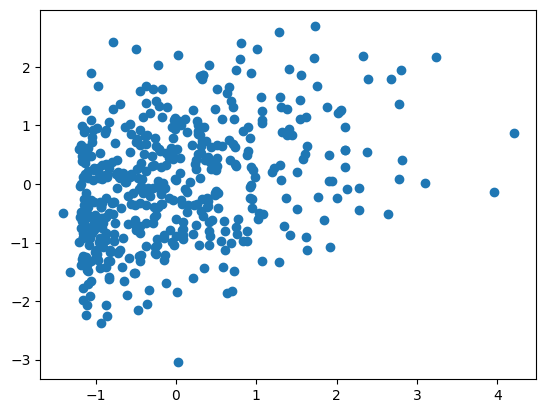

In [13]:
plt.scatter(model_data['dzdur'], model_data['LV_log'])

### MANOVA just for fun and learning

Need to read more to understand what you're supposed to conclude from a MANOVA. It tells you for each predictor whether they significantly affect the "joint outcome space", or in other words, whether they have "any effect on any linear combination of your outcomes" (according to Claude). But I don't know when that would be interesting to know about. 

In [75]:
from statsmodels.multivariate.manova import MANOVA

model_data = data[MS_patients]
model_data = zscore(model_data, skip_vars=['THALAMUS_1', 'cortical_thickness', 'brain'])

# This models all outcomes jointly
model = MANOVA.from_formula('THALAMUS_1 + brain + cortical_thickness ~ CP + age + Female + tiv', data=model_data)
results = model.mv_test()
print(results.summary())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value   Num DF  Den DF   F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda   0.0074 3.0000 461.0000 20530.7717 0.0000
         Pillai's trace   0.9926 3.0000 461.0000 20530.7717 0.0000
 Hotelling-Lawley trace 133.6059 3.0000 461.0000 20530.7717 0.0000
    Roy's greatest root 133.6059 3.0000 461.0000 20530.7717 0.0000
------------------------------------------------------------------
                                                                  
-------------------------------------------------------------------
          Female          Value   Num DF   Den DF   F Value  Pr > F
-------------------------------------------------------------------
           Wilks' lambda  0.9810  3.0000  461.0000   2.9746  0.0314
          Pi

In [ ]:
pyperclip.copy()